In [1]:
%matplotlib inline


# Tutorial for conformalized quantile regression (CQR)

We will use the sklearn california housing dataset as the base for the
comparison of the different methods available on MAPIE. Two classes will
be used: :class:`~mapie.quantile_regression.MapieQuantileRegressor` for CQR
and :class:`~mapie.regression.MapieRegressor` for the other methods.

For this example, the estimator will be :class:`~lightgbm.LGBMRegressor` with
``objective="quantile"`` as this is a necessary component for CQR, the
regression needs to be from a quantile regressor.

For the conformalized quantile regression (CQR), we will use a split-conformal
method meaning that we will split the training set into a training and
calibration set. This means using
:class:`~mapie.quantile_regression.MapieQuantileRegressor` with ``cv="split"``
and the ``alpha`` parameter already defined. Recall that the ``alpha`` is
`1 - target coverage`.

For the other type of conformal methods, they are chosen with the
parameter ``method`` of :class:`~mapie.regression.MapieRegressor` and the
parameter ``cv`` is the strategy for cross-validation. In this method, to use a
"leave-one-out" strategy, one would have to use ``cv=-1`` where a positive
value would indicate the number of folds for a cross-validation strategy.
Note that for the jackknife+ after boostrap, we need to use the
class :class:`~mapie.subsample.Subsample` (note that the `alpha` parameter is
defined in the ``predict`` for these methods).


In [2]:
import os
import warnings

from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, AnnotationBbox
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.datasets import (fetch_california_housing, load_diabetes, make_regression)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from scipy.stats import randint, uniform
import seaborn as sns

from mapie.metrics import (
    regression_coverage_score,
    regression_mean_width_score
    )
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from mapie.quantile_regression import MapieQuantileRegressor


random_state = 23
rng = np.random.default_rng(random_state)
round_to = 3

warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('../../../')

from utils_numpy import get_binning_groups

## 1. Data
The target variable of this dataset is the median house value for the
California districts. This dataset is composed of 8 features, including
variables such as the age of the house, the median income of the
neighborhood, the average numbe rooms or bedrooms or even the location in
latitude and longitude. In total there are around 20k observations.
As the value is expressed in thousands of $ we will multiply it by 100 for
better visualization (note that this will not affect the results).



In [4]:
data = fetch_california_housing(as_frame=True)
X = pd.DataFrame(data=data.data, columns=data.feature_names).drop(columns=['Latitude', 'Longitude'], axis=1)
y = pd.Series(data=data.target)

Let's now create the different splits for the dataset, with a training,
calibration and test set. Recall that the calibration set is used for
calibrating the prediction intervals.



In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_state
)
X_train, X_calib, y_train, y_calib = train_test_split(
    X_train,
    y_train,
    random_state=random_state
)

## 2. Optimizing estimator
Before estimating uncertainties, let's start by optimizing the base model
in order to reduce our prediction error. We will use the
:class:`~lightgbm.LGBMRegressor` in the quantile setting. The optimization
is performed using :class:`~sklearn.model_selection.RandomizedSearchCV`
to find the optimal model to predict the house prices.



In [6]:
# estimator = Pipeline(
#     [
#         ("poly", PolynomialFeatures()),
#         ("linear", QuantileRegressor(
#                 solver="highs",
#                 alpha=0,
#         ))
#     ]
# )
# params_distributions = {
#     "poly__degree": randint(low=0, high=10),
#     "linear__solver": ["highs", "highs-ds", "highs-ipm"],
#     "linear__alpha": uniform()
# }
# optim_model = RandomizedSearchCV(
#     estimator,
#     param_distributions=params_distributions,
#     n_jobs=-1,
#     n_iter=50,
#     cv=KFold(n_splits=5, shuffle=True),
#     verbose=-1
# )
# optim_model.fit(X_train, y_train)
# estimator_polyn_quant = optim_model.best_estimator_

In [7]:
estimator = HistGradientBoostingRegressor(
    loss='quantile',
    quantile=0.5,
    random_state=random_state
)
params_distributions = dict(
    max_depth=randint(low=3, high=20),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5, shuffle=True),
    verbose=-1
)
optim_model.fit(X_train, y_train)
estimator_hgbr = optim_model.best_estimator_

In [8]:
estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    random_state=random_state
)
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=300),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5, shuffle=True),
    verbose=-1
)
optim_model.fit(X_train, y_train)
estimator_lgbm = optim_model.best_estimator_

In [9]:
estimator = GradientBoostingRegressor(
    loss='quantile',
    alpha=0.5,
    random_state=random_state
)
params_distributions = dict(
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=300),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5, shuffle=True),
    verbose=-1
)
optim_model.fit(X_train, y_train)
estimator_gbr = optim_model.best_estimator_

## 3. Comparison of MAPIE methods
We will now proceed to compare the different methods available in MAPIE used
for uncertainty quantification on regression settings. For this tutorial we
will compare the "naive", "Jackknife plus after Bootstrap", "cv plus" and
"conformalized quantile regression". Please have a look at the theoretical
description of the documentation for more details on these methods.

We also create two functions, one to sort the dataset in increasing values
of ``y_test`` and a plotting function, so that we can plot all predictions
and prediction intervals for different conformal methods.



In [10]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    rmse,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    # axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
    # axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=error[~warnings],
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
        )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=error[warnings],
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval"
        )
    # axs.scatter(
    #     y_test_sorted_[warnings],
    #     y_test_sorted_[warnings],
    #     marker="*", color="green",
    #     label="True value"
    # )
    axs.set_xlabel("True y values")
    axs.set_ylabel("Predicted y values")
    median_lim = np.median([axs.get_xlim()])
    min_lim = np.min([axs.get_xlim(), axs.get_ylim()])
    max_lim = np.max([axs.get_xlim(), axs.get_ylim()])
    ab = AnnotationBbox(
        TextArea(
            f"RMSE: {np.round(rmse, round_to)}\n"
            + f"Coverage: {np.round(coverage, round_to)}\n"
            + f"Interval width: {np.round(width, round_to)}"
        ),
        xy=(min_lim, max_lim),
        )
    lims = [
        min_lim,  # min of both axes
        max_lim,  # max of both axes
    ]
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

We proceed to using MAPIE to return the predictions and prediction intervals.
We will use an $\alpha=0.2$, this means a target coverage of 0.8
(recall that this parameter needs to be initialized directly when setting
:class:`~mapie.quantile_regression.MapieQuantileRegressor` and when using
:class:`~mapie.regression.MapieRegressor`, it needs to be set in the
``predict``).
Note that for the CQR, there are two options for ``cv``:

* ``cv="split"`` (by default), the split-conformal where MAPIE trains the
  model on a training set and then calibrates on the calibration set.
* ``cv="prefit"`` meaning that you can train your models with the correct
  quantile values (must be given in the following order:
  $(\alpha, 1-(\alpha/2), 0.5)$ and given to MAPIE as an iterable
  object. (Check the examples for how to use prefit in MAPIE)

Additionally, note that there is a list of accepted models by
:class:`~mapie.quantile_regression.MapieQuantileRegressor`
(``quantile_estimator_params``) and that we will use symmetrical residuals.



In [11]:
name = "estimators"
dir_ = "images/"+name+"/"
if not os.path.exists(dir_):
    os.mkdir(dir_)

In [12]:
STRATEGIES = {
    "lgbm": estimator_lgbm,
    "gbr": estimator_gbr,
    "hgbr": estimator_hgbr,
}
y_pred, y_pis = {}, {}
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width, rmse = {}, {}, {}
for estimator_name, estimator in STRATEGIES.items():
    mapie = MapieQuantileRegressor(estimator, method="quantile", cv="split", alpha=0.2)
    mapie.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib)
    y_pred[estimator_name], y_pis[estimator_name] = mapie.predict(X_test)
    (
        y_test_sorted[estimator_name],
        y_pred_sorted[estimator_name],
        lower_bound[estimator_name],
        upper_bound[estimator_name]
    ) = sort_y_values(y_test, y_pred[estimator_name], y_pis[estimator_name])
    rmse[estimator_name] = mean_squared_error(y_test_sorted[estimator_name], y_pred_sorted[estimator_name])
    coverage[estimator_name] = regression_coverage_score(
        y_test,
        y_pis[estimator_name][:, 0, 0],
        y_pis[estimator_name][:, 1, 0]
        )
    width[estimator_name] = regression_mean_width_score(
        y_pis[estimator_name][:, 0, 0],
        y_pis[estimator_name][:, 1, 0]
        )

We will now proceed to the plotting stage, note that we only plot 2% of the
observations in order to not crowd the plot too much.



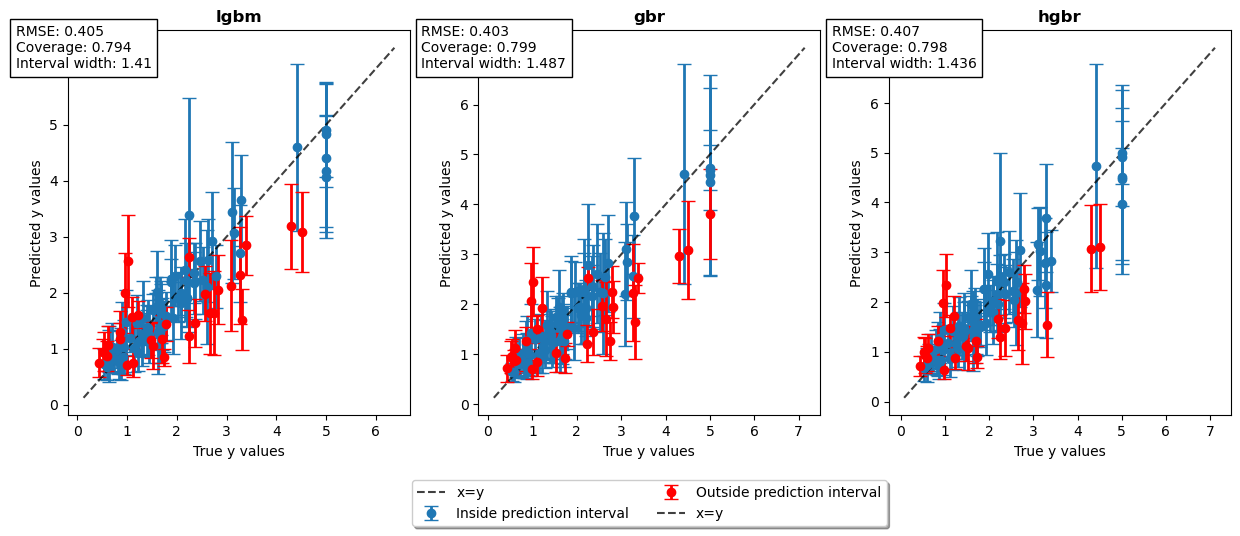

In [13]:
perc_obs_plot = 0.02
num_plots = rng.choice(
    len(y_test), int(perc_obs_plot*len(y_test)), replace=False
    )
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for strategy, coord in zip(STRATEGIES, axs):
    plot_prediction_intervals(
        strategy,
        coord,
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy],
        coverage[strategy],
        width[strategy],
        rmse[strategy], 
        num_plots
        )
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)]
plt.legend(
    lines[:4], labels[:4],
    loc='upper center',
    bbox_to_anchor=(-0.7, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2
)
plt.savefig("images/"+name+"/"+name+"_plotintervals.png", bbox_inches="tight")
plt.show()

We notice more adaptability of the prediction intervals for the
conformalized quantile regression while the other methods have fixed
interval width. Indeed, as the prices get larger, the prediction intervals
are increased with the increase in price.



In [14]:
def get_coverages_widths_by_bins(
    want,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins,
    bin_strategy,
):
    """
    Given the results from MAPIE, this function split the data
    according the the test values into bins and calculates coverage
    or width per bin.
    """
    # cuts = []
    # cuts_ = pd.qcut(y_test["naive"], bins).unique()[:-1]
    # for item in cuts_:
    #     cuts.append(item.left)
    # cuts.append(cuts_[-1].right)
    # cuts.append(np.max(y_test["naive"])+1)
    bins, _ = get_binning_groups(y_test["lgbm"], bins+1, bin_strategy)
    recap = {}
    for i in range(len(bins) - 1):
        cut1, cut2 = bins[i], bins[i+1]
        name = f"[{np.round(cut1, 2)}, {np.round(cut2, 2)}]"
        recap[name] = []
        for strategy in STRATEGIES:
            indices = np.where(
                (y_test[strategy] > cut1) * (y_test[strategy] <= cut2)
                )
            y_test_trunc = np.take(y_test[strategy], indices)
            y_low_ = np.take(lower_bound[strategy], indices)
            y_high_ = np.take(upper_bound[strategy], indices)
            if want == "coverage":
                recap[name].append(regression_coverage_score(
                    y_test_trunc[0],
                    y_low_[0],
                    y_high_[0]
                ))
            elif want == "width":
                recap[name].append(
                    regression_mean_width_score(y_low_[0], y_high_[0])
                )
    recap_df = pd.DataFrame(recap, index=STRATEGIES)
    return recap_df


To confirm these insights, we will now observe what happens when we plot
the conditional coverage and interval width on these intervals splitted by
quantiles.



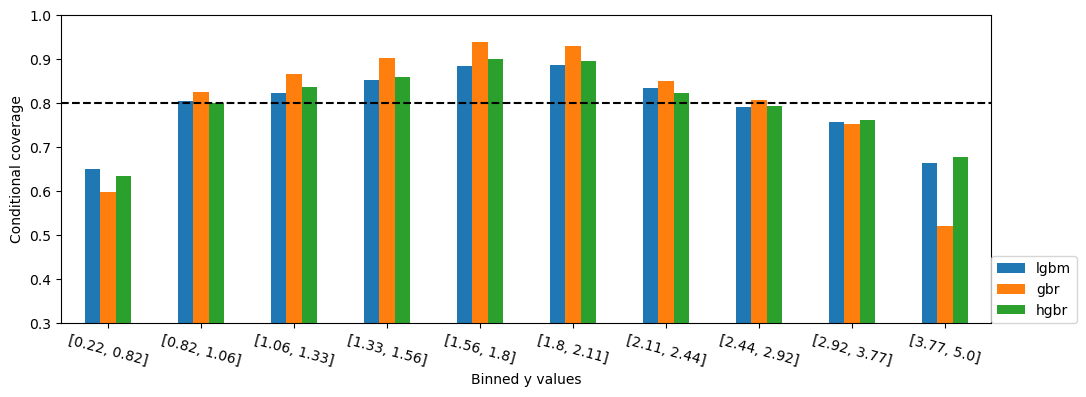

In [15]:
bins = 10
bin_strategy = "quantile"
binned_data = get_coverages_widths_by_bins(
    "coverage",
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins=bins,
    bin_strategy=bin_strategy
)

binned_data.T.plot.bar(figsize=(12, 4))
plt.axhline(0.80, ls="--", color="k")
plt.ylabel("Conditional coverage")
plt.xlabel("Binned y values")
plt.xticks(rotation=345)
plt.ylim(0.3, 1.0)
plt.legend(loc=[1, 0])
plt.savefig("images/"+name+"/"+name+"_barcoverage.png", bbox_inches="tight")
plt.show()

What we observe from these results is that none of the methods seems to
have conditional coverage at the target $1 - \alpha$. However, we can
clearly notice that the CQR seems to better adapt to large prices. Its
conditional coverage is closer to the target coverage not only for higher
prices, but also for lower prices where the other methods have a higher
coverage than needed. This will very likely have an impact on the widths
of the intervals.



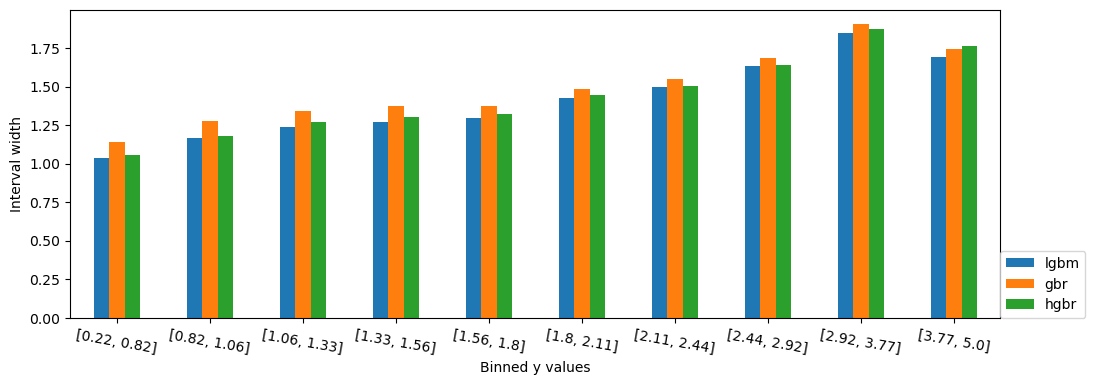

In [16]:
binned_data = get_coverages_widths_by_bins(
    "width",
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    STRATEGIES,
    bins=bins,
    bin_strategy=bin_strategy
)

binned_data.T.plot.bar(figsize=(12, 4))
plt.ylabel("Interval width")
plt.xlabel("Binned y values")
plt.xticks(rotation=350)
plt.legend(loc=[1, 0])
plt.savefig("images/"+name+"/"+name+"_barintervals.png", bbox_inches="tight")
plt.show()

When observing the values of the the interval width we again see what was
observed in the previous graphs with the interval widths. We can again see
that the prediction intervals are larger as the price of the houses
increases, interestingly, it's important to note that the prediction
intervals are shorter when the estimator is more certain.

